# Relationship of the decoherence with random Z rotations

In [1]:
import numpy as np
from qutip import *
import pymatching as pym

import matplotlib.pyplot as plt

from timeit import timeit
import tqdm as tq

from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
rng = np.random.default_rng(123) # Construct a new Generator with the default BitGenerator (PCG64). The seed here is '123'

In [3]:
# Function for initializtion of the state
def init_qp():
    psi1 = tensor(basis(2,0), basis(2,0), basis(2,0), basis(2,0), basis(2,0), basis(2,0), basis(2,0), basis(2,0), basis(2,0))
    return psi1

# Defining the initial state
psi_init = init_qp()

In [4]:
'''
Defining Pauli matrices for a qubits in the surface code 
- xi = X gate for the ith qubit
- zi = Z gate for the ith qubit 
- We have 9 qubits so the range of i is - i = 0,1,...8
'''

I_9 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)) # Identity for the 9 qubit system

x0 = tensor(sigmax(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
x1 = tensor(qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
x2 = tensor(qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
x3 = tensor(qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
x4 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2))
x5 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2))
x6 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2))
x7 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2))
x8 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmax())

z0 = tensor(sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
z1 = tensor(qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
z2 = tensor(qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
z3 = tensor(qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
z4 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2))
z5 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2))
z6 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2))
z7 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2))
z8 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmaz())

y0 = tensor(sigmay(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
y1 = tensor(qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
y2 = tensor(qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
y3 = tensor(qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
y4 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2))
y5 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2))
y6 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2))
y7 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2))
y8 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmay())

# Defining Hadamard gate for all the nine qubits ( acting simultaneously)

h = (sigmax() + sigmaz())/(2**0.5) # Hadamard for a single qubit

h1 = tensor(h,qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)) # Hadamard for a single qubit in the surface code

H  = tensor(h,h,h,h,h,h,h,h,h) # Hadamard for all qbuits(simultaneously) in the surface code

Z = tensor(sigmaz(),sigmaz(),sigmaz(),sigmaz(),sigmaz(),sigmaz(),sigmaz(),sigmaz(),sigmaz())
X = tensor(sigmax(),sigmax(),sigmax(),sigmax(),sigmax(),sigmax(),sigmax(),sigmax(),sigmax())

Z_set = [z0,z1,z2,z3,z4,z5,z6,z7,z8]
X_set = [x0,x1,x2,x3,x4,x5,x6,x7,x8]
Y_set = [y0,y1,y2,y3,y4,y5,y6,y7,y8]

# Defning the Stabilizers as si = stabilizer measured by the ith measurement bit (i=9,10,..16)

s9  = x1 * x2
s10 = z0 * z3
s11 = x0 * x1 * x3 * x4
s12 = z1 * z2 * z4 * z5
s13 = z3 * z4 * z6 * z7
s14 = x4 * x5 * x7 * x8
s15 = z5 * z8
s16 = x6 * x7

stab_set = [s9,s10,s11,s12,s13,s14,s15,s16]

xstab_set = [0,2,5,7]
zstab_set = [1,3,4,6]

# Defining the sub = projectors -  pi = projector for each stabilizer and i is the measurement qubit
# The projector P = p9 x p10 x p11 ... x p16

p9  = ( I_9 + s9  )/2
p10 = ( I_9 + s10 )/2
p11 = ( I_9 + s11 )/2
p12 = ( I_9 + s12 )/2
p13 = ( I_9 + s13 )/2
p14 = ( I_9 + s14 )/2
p15 = ( I_9 + s15 )/2
p16 = ( I_9 + s16 )/2

P  = 8 * p9 * p10 * p11 * p12 * p13 * p14 * p15 * p16

Px = 4 * p9 * p11 * p14 * p16
Pz = 4 * p10 * p12 * p13 * p15

# Defining Logical Operators

XL = x2 * x4 * x6
ZL = z0 * z4 * z8
HL = np.sqrt(.5)* (ZL + XL)

In [5]:
# Quiescent State
psi_seed = Px * psi_init

psi_plus = HL * psi_seed

## Defining Projective Measurement

In [6]:
def proj_measurement(Gate,psi):
    prob = expect(0.5*(I_9 + Gate),psi)
    n = rng.random()
    if prob > n:
        eigen = 1
        psi = (I_9 + Gate) * psi
        return eigen , psi.unit()
    else:
        eigen = -1
        psi = (I_9 - Gate) * psi
        if psi.norm() < 1e-10:
            return eigen , psi
        return eigen,psi.unit()

## Implementing Various Noise Models

In [7]:
def noise_model(state,pr):
    p_Z = pr
    p_I = 1 - pr
    events = [0,1] # 0 - for no error; 1 - phase-flip error 
    for qubit in range(9):
        event = rng.choice(events,p=[p_I,p_Z],size=1)
        if 1 in event:
            f = 'z' + str(qubit)
            state = eval(f) * state
    return state

## Implementing Coherent errors

In [8]:
def coherent_noise(psi,theta):
    z = Qobj([[np.exp(1j*theta),0],[0,np.exp(-1j*theta)]])  
    exp_z0 = tensor(z,qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
    exp_z1 = tensor(qeye(2),z,qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
    exp_z2 = tensor(qeye(2),qeye(2),z,qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
    exp_z3 = tensor(qeye(2),qeye(2),qeye(2),z,qeye(2),qeye(2),qeye(2),qeye(2),qeye(2))
    exp_z4 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),z,qeye(2),qeye(2),qeye(2),qeye(2))
    exp_z5 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),z,qeye(2),qeye(2),qeye(2))
    exp_z6 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),z,qeye(2),qeye(2))
    exp_z7 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),z,qeye(2))
    exp_z8 = tensor(qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),z)
    Z = exp_z0 * exp_z1 * exp_z2 * exp_z3 * exp_z4 * exp_z5 * exp_z6 * exp_z7 * exp_z8
    psi = Z * psi
    return psi

## Implementing Phase Damping Channel

In [9]:
def phase_damping(psi,p_PD):
    p_Z = (1 - np.sqrt(1 - p_PD)) * 0.5
    p_I = 1 - p_Z 
    for qubit in range(9):
        n = rng.random()
        if n < p_Z:
            psi = Z_set[qubit] * psi
    return psi.unit()

## Random Rotations on the z-axis

In [10]:
def rand_zrot(psi,sigma):
    random_seed = int(np.random.random() * 1000)
    rng = np.random.default_rng(random_seed)
    theta_set = rng.normal(0,sigma,9)
    Z = 1
    for i in range(9):
        exp_op = (-0.5j * theta_set[i] * Z_set[i]).expm()
        Z = Z * exp_op
    psi = Z * psi
    return psi

## Defining Syndrome Measurement

In [11]:
def syndrome(psi): # Returns the Syndrome - Expectation values of all the stabilizers
    syn = []
    for stab in stab_set:
        syn_val,psi = proj_measurement(stab,psi) 
        syn.append(syn_val)
    return syn,psi
def prob_coherent(stabs,psi,syn):
    P = 1
    for stab,sf in zip(stabs,syn):
        P = P * (0.5 * (I_9 + sf * stab))
    psi = P * psi
    prob = (psi.norm())**2
    if prob == 0:
        return psi,prob
    else:
        return psi.unit(),prob
    return None

## Defining Check Matrix for decoding

In [12]:
Hz = np.array([
    [1,0,1,0,0,0,0,0,0],
    [0,1,1,0,1,1,0,0,0],
    [0,0,0,1,1,0,1,1,0],
    [0,0,0,0,0,1,0,0,1]])

Hx = np.array([
    [0,1,1,0,0,0,0,0,0],
    [1,1,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,1,1],
    [0,0,0,0,0,0,1,1,0]])

mz = pym.Matching(Hz);
mx = pym.Matching(Hx);

## Simulation for phase-flip errors with probability - p

In [13]:
# Defining Simulation function - runs the noise model n times with prob of error p.
def simulation(n,p,psi):
    decoded_states = 0
    for i in range(n):
        psi = psi.unit()
        psi = noise_model(psi,p)
        synd , psi = syndrome(psi)      
        syn = np.zeros(4)

        l = 0
        for j in xstab_set: 
            syn[l] = synd[j]
            l = l+1
        corc = mx.decode((syn-1)/-2)
        for k in range(9):
            if corc[k]==1:
                psi = Z_set[k] * psi
        eigen,psi = proj_measurement(XL,psi)
        if eigen==1:
            decoded_states = decoded_states + 1
        else:
            psi = ZL * psi
    return decoded_states

## Simulation for Coherent Noise

In [14]:
pos_syn = [[1,1,1,1],[-1,1,1,1],[1,-1,1,1],[1,1,-1,1],[1,1,1,-1],
        [-1,-1,1,1],[-1,1,-1,1],[-1,1,1,-1],[1,-1,-1,1],[1,-1,1,-1],[1,1,-1,-1],
        [-1,-1,-1,1],[-1,-1,1,-1],[-1,1,-1,-1],[1,-1,-1,-1],
        [-1,-1,-1,-1]]

def simulation_coherent(psi,theta):
    rot_psi = coherent_noise(psi,theta)
    fid = 0
    p_s = np.zeros(16)
    norm = np.zeros(16)
    for i in range(16):
        a0=i//8%2
        a1=i//4%2
        a2=i//2%2
        a3=i%2      
        syn_x = np.array([a0,a1,a2,a3])*(-2) + 1
        psi,p_s[i]= prob_coherent([s9,s11,s14,s16],rot_psi,syn_x)
        corc = mx.decode(np.array([a0,a1,a2,a3]))
        for k in range(9):
            if corc[k]==1:
                psi = Z_set[k] * psi                         
        normi = (psi.dag() * psi_plus).full()[0][0]
        norm[i] = np.abs(normi)**2
        fid = fid + p_s[i] * norm[i]
    return 1-fid

## Simulation for Phase Damping Channel

In [15]:
def simulation_pdamp(n,p_PD,psi):
    decoded_states = 0
    for i in range(n):
        psi = phase_damping(psi,p_PD)
        synd , psi = syndrome(psi)     

        syn_z = np.zeros(4)
        
        l = 0
        for j in xstab_set: 
            syn_z[l] = synd[j]
            l = l+1
        corc_z = mx.decode((syn_z-1)/-2)
        for k in range(9):
            if corc_z[k]==1:
                psi = Z_set[k] * psi
        eigen,psi = proj_measurement(XL,psi)
        if eigen==1:
            decoded_states = decoded_states + 1
        else:
            psi = ZL * psi
    return decoded_states

## Simulation for random Z rotations

In [16]:
# Defining Simulation function - runs the noise model n times with prob of error p.
def simulation_rand_zrot(n,sigma,psi):
    decoded_states = 0
    for i in range(n):
        psi = rand_zrot(psi,sigma)
        synd , psi = syndrome(psi)      
        syn = np.zeros(4)

        l = 0
        for j in xstab_set: 
            syn[l] = synd[j]
            l = l+1
        corc = mx.decode((syn-1)/-2)
        for k in range(9):
            if corc[k]==1:
                psi = Z_set[k] * psi
        eigen,psi = proj_measurement(XL,psi)
        if eigen==1:
            decoded_states = decoded_states + 1
        else:
            psi = ZL * psi
    return decoded_states

# Plotting graph for uncorellated noise model

In [17]:
def plot_err(N,prob_n,psi_seed):  
    prob_range = np.linspace(0,1,num=prob_n)
    n_deco = np.zeros(prob_n)
    j = 0
    for i in tq.tqdm(range(len(prob_range))):        
        n_deco[j] = simulation(N,prob_range[i],psi_seed)
        j = j + 1
    
    err_rate = 1-n_deco/N
    
    plt.figure(dpi=110)
    plt.subplot(111)

    plt.title('Probability of Error (' +str(prob_n) +'prob res ) ' + 'vs Logical Error rate ('+str(N)+ ' samples)')
    
    plt.grid()

    plt.xlabel('Probability of Error - $p$')
    plt.ylabel('Logical Error rate - $ P_L $')
    
    plt.plot(prob_range,err_rate,marker="",c='k',ms='2',label='Error line',lw=.8)
    plt.plot(prob_range,prob_range,ls='--',c='b',label='Straight line ($P_L=p$)',alpha=.5)
    
    plt.legend(fontsize='x-small')
    #plt.savefig(fname='Error plot '+str(N)+'_'+str(prob_n))
    return None

# Plotting for coherent errors

In [18]:
def plot_err_cohe(N):
    res = 50
    prob_range = np.linspace(0,1,num=res)
    n_deco = np.zeros(res)
    j = 0
    for i in tq.tqdm(range(len(prob_range))):        
        n_deco[j] = simulation(N,prob_range[i],psi_seed)
        j = j + 1
    
    err_rate = 1-n_deco/N
    P_l = np.zeros(50)
    res = np.linspace(0,np.pi/2,50)
    for i in range(50):
        P_l[i] = simulation_coherent(psi_plus,res[i])

    plt.figure(dpi=120)
    plt.title('Probability of Error ' + 'vs Logical Error rate')
    plt.grid() 
    
    plt.yticks(np.linspace(0,1,11))
    plt.xticks(np.linspace(0,1,11)) 
    
    plt.xlabel('Probability of Error - $p$')
    plt.ylabel('Logical Error rate - $ P_L $')
    
    plt.plot(np.sin(res)**2,P_l)
    plt.plot(prob_range,err_rate,marker="",c='k',ms='2',label='Error line',lw=.8)
    plt.plot(prob_range,prob_range,ls='--',c='b',label='Straight line ($P_L=p$)',alpha=.5)
    
    plt.legend(fontsize='x-small')
    plt.show()

# Plotting for the phase damping error

In [19]:
def plot_err_phase(N,prob_n,psi):  
    prob_range = np.linspace(0,1,num=prob_n)
    n_deco = np.zeros(prob_n)
    j = 0
    for prob in tq.tqdm(prob_range):        
        n_deco[j] = simulation_pdamp(N,prob,psi)
        j = j + 1
    p_Z = (1 - np.sqrt(1 - prob_range)) * 0.5
    err_rate = 1-n_deco/N
    
    plt.figure(dpi=110)
    plt.subplot(111)

    plt.title('Phase Damping ' + 'vs Logical Error rate ')  
    plt.grid()
    
    plt.xlabel('Probability of Phase Flip - $P_{Z}$')
    plt.ylabel('Logical Error rate - $ P_L $')
    
    plt.yticks(np.linspace(0,np.around(np.max(err_rate), decimals=1),11))
    plt.xticks(np.linspace(0,1,11))
    
    plt.plot(p_Z,err_rate,marker="",c='k',ms='2',label='Error line',lw=.8)
    #plt.plot(prob_range,prob_range,ls='--',c='b',label='Straight line ($P_L=p$)',alpha=.5)
    
    plt.legend(fontsize='x-small')
    #plt.savefig(fname='Error plot '+str(N)+'_'+str(prob_n))
    return None

# Plotting for the random Z rotations

In [20]:
def plot_err_rand_zrot(N,sigma_res,psi):  
    sigma_range = np.linspace(0,3,num=sigma_res)
    n_deco = np.zeros(sigma_res)
    j = 0
    
    for sigma in tq.tqdm(sigma_range):        
        n_deco[j] = simulation_rand_zrot(N,sigma,psi)
        j = j + 1
    
    err_rate = 1-n_deco/N
    
    plt.figure(dpi=110)
    plt.subplot(111)

    plt.title('Sigma ' + 'vs Logical Error rate ')
    plt.grid()
    
    plt.xlabel(' Sigma $\sigma$')
    plt.ylabel('Logical Error rate - $ P_L $')

    plt.yticks(np.linspace(0,np.around(np.max(err_rate), decimals=1),11))
    plt.xticks(np.linspace(0,3,11))
    
    plt.plot(sigma_range,err_rate,marker="",c='k',ms='2',label='Error line',lw=.8)
    #plt.plot(sigma_range,sigma_range,ls='--',c='b',label='Straight line ($P_L=p$)',alpha=.5)
    
    plt.legend(fontsize='x-small')
    #plt.savefig(fname='Error plot '+str(N)+'_'+str(sigma_res))
    return None

In [21]:
#plot_err_phase(200,200,psi_plus)

In [22]:
#plot_err_rand_zrot(20,20,psi_plus)

### Phase damping as random z rotations with angles sampled from a Guassian ($\mu = 0,\sigma$) 
## $ P_Z = \frac{1-e^{\sigma^2/2}}{2} $ 

## or

## $ \sigma = \sqrt{-2\log(1-2P_Z)} $

In [23]:
N = 300
res = 50
psi = psi_plus
prob_range = np.linspace(0.001,.9999,res)
p_Z = (1 - np.sqrt(1 - prob_range)) * 0.5
sigma_range = np.sqrt(-2 * np.log( 1 - 2*p_Z))

n_deco_damp = np.zeros(res)
n_deco_rand = np.zeros(res)

for sigma,p_pd,j in zip(tq.tqdm(sigma_range),prob_range,range(res)):  
    n_deco_rand[j] = simulation_rand_zrot(N,sigma,psi)
    n_deco_damp[j] = simulation_pdamp(N,p_pd,psi)

err_rate_rand = 1-n_deco_rand/N
err_rate_damp = 1-n_deco_damp/N

max_val = np.max(np.maximum(err_rate_rand,err_rate_damp))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:05<00:00,  4.91s/it]


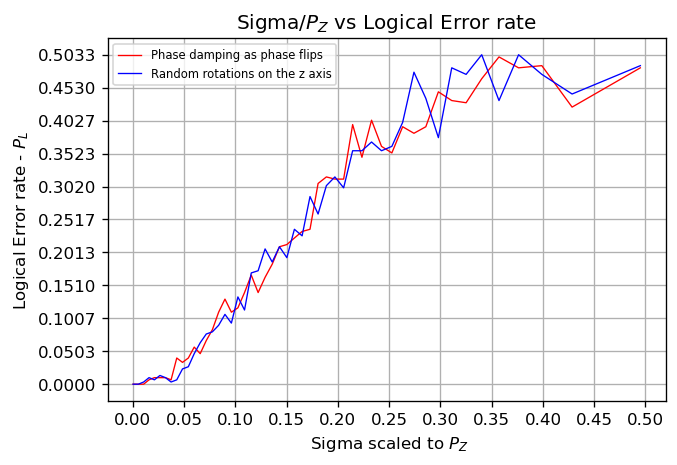

In [24]:
plt.figure(dpi=120)
plt.subplot(111)

plt.title('Sigma/$P_Z$ ' + 'vs Logical Error rate ')
plt.grid()

plt.xlabel(' Sigma scaled to $P_Z$')
plt.ylabel('Logical Error rate - $ P_L $')

plt.yticks(np.linspace(0,max_val,11))
plt.xticks(np.linspace(0,.5,11))

plt.plot(p_Z,err_rate_damp,marker="",c='r',ms='2',label='Phase damping as phase flips',lw=.8)
plt.plot(p_Z,err_rate_rand,marker="",c='b',ms='2',label='Random rotations on the z axis',lw=.8)


plt.legend(fontsize='x-small')
plt.savefig(fname='P_z scaled to sigma')
plt.show()

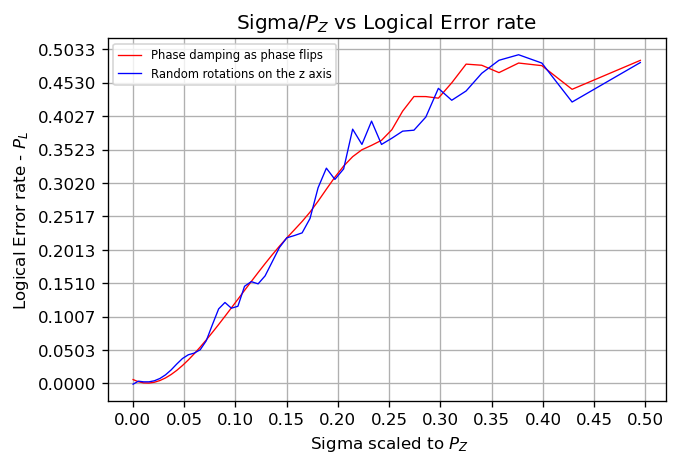

In [25]:
smooth_damp = InterpolatedUnivariateSpline(p_Z, err_rate_rand)
smooth_rand = InterpolatedUnivariateSpline(sigma_range, err_rate_damp)
smooth_factor = 15 * 1e-3
smooth_damp.set_smoothing_factor(smooth_factor)
smooth_rand.set_smoothing_factor(smooth_factor/5)

plt.figure(dpi=120)
plt.subplot(111)

plt.title('Sigma/$P_Z$ ' + 'vs Logical Error rate ')
plt.grid()

plt.xlabel(' Sigma scaled to $P_Z$')
plt.ylabel('Logical Error rate - $ P_L $')

plt.yticks(np.linspace(0,max_val,11))
plt.xticks(np.linspace(0,.5,11))

#plt.plot(p_Z,err_rate_damp,marker="",c='r',ms='2',label='Phase damping as phase flips',lw=.8)
#plt.plot(p_Z,err_rate_rand,marker="",c='b',ms='2',label='Random rotations on the z axis',lw=.8)

plt.plot(p_Z,smooth_damp(p_Z),marker="",c='r',ms='2',label='Phase damping as phase flips',lw=.8)
plt.plot(p_Z,smooth_rand(sigma_range),marker="",c='b',ms='2',label='Random rotations on the z axis',lw=.8)

plt.legend(fontsize='x-small')
plt.savefig(fname='P_z scaled to sigma - smoothed')
plt.show()